# 1. Getting Started & Configuration

In [15]:

# This notebook loads the data, computes baseline metrics, trains & tunes models,
# evaluates & calibrates them, explains top drivers, and designs an A/B experiment.

# Consolidated imports & logging
import os, logging
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, brier_score_loss, roc_curve
)
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from statsmodels.stats.power import NormalIndPower

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    logger.warning("`shap` not installed; skipping SHAP explainability.")


# Reproducibility
SEED = 42
np.random.seed(SEED)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger("EmailCampaign")

# Ensure data files present
for fname in ["email_table.csv","email_opened_table.csv","link_clicked_table.csv"]:
    if not os.path.isfile(fname):
        raise FileNotFoundError(f"Missing required file: {fname}")


# 2. Data Loading & Baseline Metrics

In [71]:
# Load & Merge
email_table = pd.read_csv('https://raw.githubusercontent.com/KanchanMaan/Email_Campaign_case_study/refs/heads/main/email_campaign_files/email_table.csv')
email_opened = pd.read_csv('https://raw.githubusercontent.com/KanchanMaan/Email_Campaign_case_study/refs/heads/main/email_campaign_files/email_opened_table.csv')
link_clicked = pd.read_csv('https://raw.githubusercontent.com/KanchanMaan/Email_Campaign_case_study/refs/heads/main/email_campaign_files/link_clicked_table.csv')

# Flags for opened & clicked
email_table["opened"]  = email_table["email_id"].isin(email_opened["email_id"]).astype(int)
email_table["clicked"] = email_table["email_id"].isin(link_clicked["email_id"]).astype(int)

# Baseline metrics
total = len(email_table)
opens = email_table["opened"].sum()
clicks= email_table["clicked"].sum()
logger.info(f"Sent={total:,}, Opens={opens:,} ({opens/total:.2%}), Clicks={clicks:,} ({clicks/total:.2%})")


2025-04-23 02:26:44 INFO Sent=100,000, Opens=10,345 (10.35%), Clicks=2,119 (2.12%)


In [72]:
email_table.describe(include='all')

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
count,100000.000000,100000,100000,100000.000000,100000,100000,100000.00000,100000.000000,100000.000000
unique,NaN,2,2,NaN,7,4,NaN,NaN,NaN
top,NaN,long_email,generic,NaN,Saturday,US,NaN,NaN,NaN
freq,NaN,50276,50209,NaN,14569,60099,NaN,NaN,NaN
mean,498690.196160,NaN,NaN,9.059300,NaN,NaN,3.87845,0.103450,0.021190
std,289230.727534,NaN,NaN,4.439637,NaN,NaN,3.19611,0.304547,0.144018
min,8.000000,NaN,NaN,1.000000,NaN,NaN,0.00000,0.000000,0.000000
25%,246708.250000,NaN,NaN,6.000000,NaN,NaN,1.00000,0.000000,0.000000
50%,498447.000000,NaN,NaN,9.000000,NaN,NaN,3.00000,0.000000,0.000000
75%,749942.750000,NaN,NaN,12.000000,NaN,NaN,6.00000,0.000000,0.000000


# 3. EDA

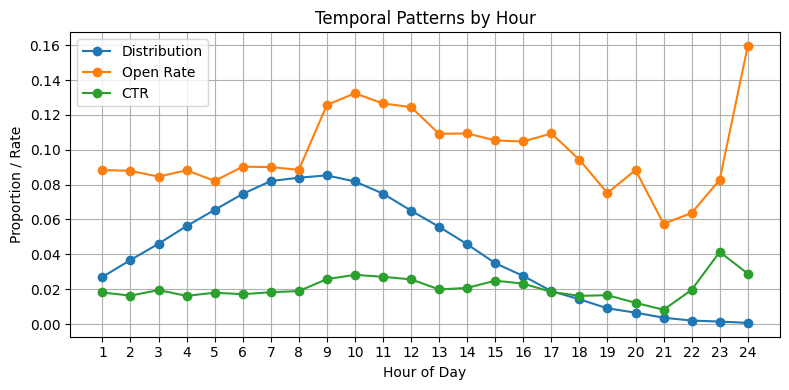

2025-04-23 02:26:46 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-23 02:26:46 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-23 02:26:46 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-23 02:26:46 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-23 02:26:46 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

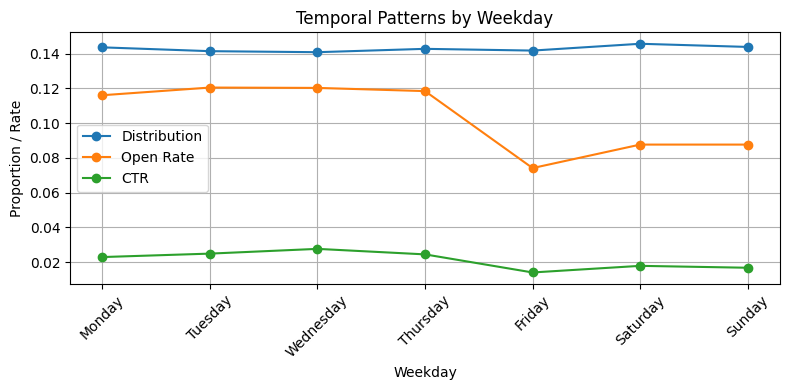

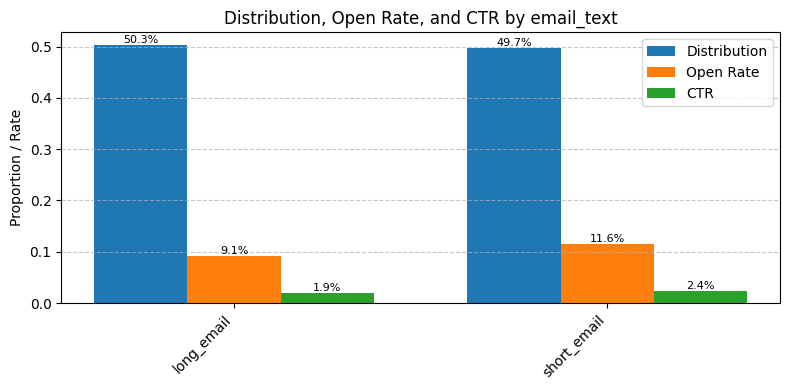

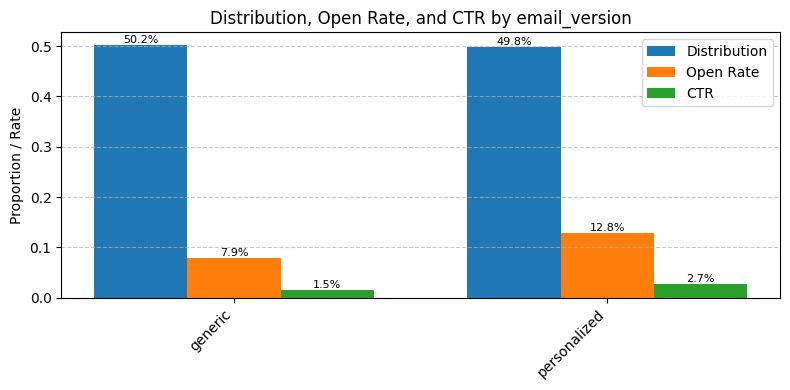

C:\Users\KANCHAN MAAN\AppData\Local\Temp\ipykernel_12620\3438804326.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby(feature).agg(


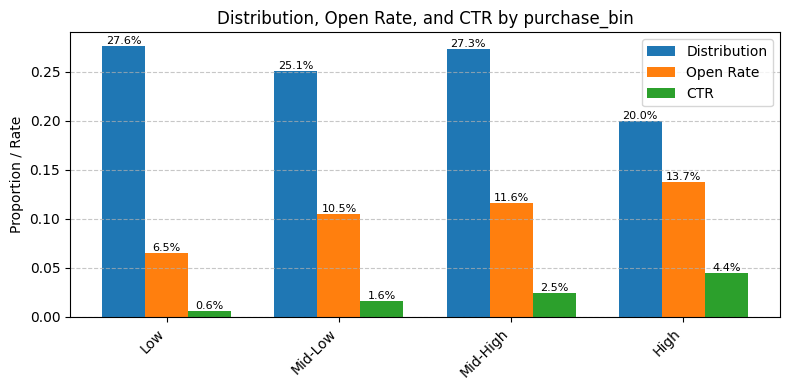

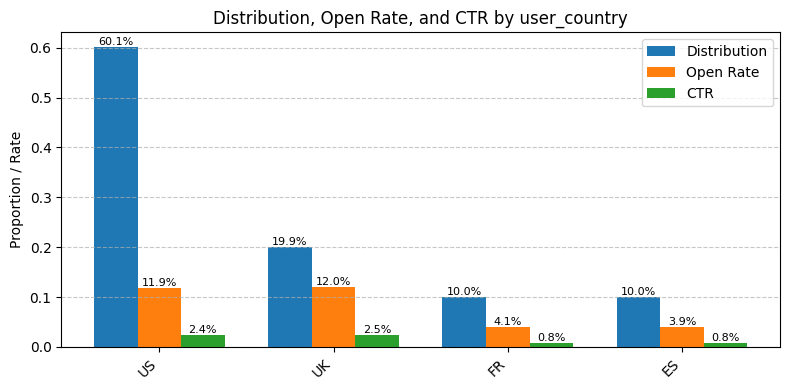

In [73]:

# Compute purchase bins
email_table['purchase_bin'] = pd.qcut(
    email_table['user_past_purchases'].fillna(0),
    4, labels=['Low','Mid-Low','Mid-High','High']
)

# Helper for metrics
def compute_perf(df, feature):
    grp = df.groupby(feature).agg(
        count=('email_id', 'count'),
        opens=('opened', 'sum'),
        clicks=('clicked', 'sum')
    )
    grp['distribution'] = grp['count'] / grp['count'].sum()
    grp['open_rate'] = grp['opens'] / grp['count']
    grp['ctr'] = grp['clicks'] / grp['count']
    return grp[['distribution', 'open_rate', 'ctr']]

# === Temporal Charts: hour and weekday ===
# Hour
perf_hour = compute_perf(email_table, 'hour').sort_index()
plt.figure(figsize=(8,4))
plt.plot(perf_hour.index, perf_hour['distribution'], marker='o', label='Distribution')
plt.plot(perf_hour.index, perf_hour['open_rate'], marker='o', label='Open Rate')
plt.plot(perf_hour.index, perf_hour['ctr'], marker='o', label='CTR')
plt.title('Temporal Patterns by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion / Rate')
plt.xticks(perf_hour.index)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekday with defined order
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
perf_wd = compute_perf(email_table, 'weekday').reindex(weekday_order)
plt.figure(figsize=(8,4))
plt.plot(perf_wd.index, perf_wd['distribution'], marker='o', label='Distribution')
plt.plot(perf_wd.index, perf_wd['open_rate'], marker='o', label='Open Rate')
plt.plot(perf_wd.index, perf_wd['ctr'], marker='o', label='CTR')
plt.title('Temporal Patterns by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Proportion / Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Clustered Bar Charts with Annotations for Non-Temporal Features ===
non_temp = ['email_text', 'email_version', 'purchase_bin', 'user_country']

for feature in non_temp:
    df_perf = compute_perf(email_table, feature)
    if feature == 'user_country':
        df_perf = df_perf.sort_values('distribution', ascending=False).head(6)
    labels = df_perf.index.astype(str)
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(8,4))
    bars1 = ax.bar(x - width, df_perf['distribution'], width, label='Distribution')
    bars2 = ax.bar(x,         df_perf['open_rate'],   width, label='Open Rate')
    bars3 = ax.bar(x + width, df_perf['ctr'],         width, label='CTR')

    def annotate(bars, fmt):
        for bar in bars:
            y = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2, y,
                fmt.format(y), ha='center', va='bottom', fontsize=8
            )

    annotate(bars1, "{:.1%}")
    annotate(bars2, "{:.1%}")
    annotate(bars3, "{:.1%}")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f'Distribution, Open Rate, and CTR by {feature}')
    ax.set_ylabel('Proportion / Rate')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


**Campaign Metrics**

In [74]:
# Calculate overall campaign metrics

# Total number of emails sent
total_emails = email_table.shape[0]

# Number of emails that were opened
opened_emails = email_table['opened'].sum()

# Number of emails where the link was clicked
clicked_emails = email_table['clicked'].sum()

# Open Rate: Percentage of emails that were opened
open_rate = opened_emails / total_emails

# Click-Through Rate (CTR): Percentage of emails that led to a click
ctr = clicked_emails / total_emails

print("Campaign Metrics:")
print(f"Total Emails Sent: {total_emails}")
print(f"Emails Opened: {opened_emails} ({open_rate*100:.2f}%)")
print(f"Emails Clicked: {clicked_emails} ({ctr*100:.2f}%)")

Campaign Metrics:
Total Emails Sent: 100000
Emails Opened: 10345 (10.35%)
Emails Clicked: 2119 (2.12%)


# 4. Feature Engineering

In [75]:
# One‑hot & interactions
df = pd.get_dummies(
    email_table,
    columns=["email_text","email_version","weekday","user_country","purchase_bin"],
    drop_first=True
)
# Interaction: personalized × high‑value
if "email_version_personalized" in df and "purchase_bin_High" in df:
    df["personalized_x_high"] = (
        df["email_version_personalized"] * df["purchase_bin_High"]
    )

X = df.drop(columns=["email_id","opened","clicked"])
y = df["clicked"]


# 5. Train/Test Split

In [76]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=SEED
)


# 6. Model Training, Tuning & Calibration

In [77]:
# GridSearchCV for LR & RF
models = {
    "Logistic": (
        LogisticRegression(class_weight="balanced", random_state=SEED, solver="liblinear"),
        {"C":[0.01,0.1,1,10]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=SEED, n_jobs=-1),
        {"n_estimators":[100,200],"max_depth":[None,10,20]}
    )
}

cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
best_models = {}

for name,(mdl,params) in models.items():
    grid = GridSearchCV(mdl, params, scoring="roc_auc", cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    logger.info(f"{name} best_params={grid.best_params_}, CV_ROC_AUC={grid.best_score_:.3f}")
    best_models[name] = grid.best_estimator_

# Calibrate
# Assuming best_models = {'Logistic': <LR instance>, 'RandomForest': <RF instance>}
calibrated = {}
for name, mdl in best_models.items():
    # choose calibration method per model
    method = 'isotonic' if name == 'Logistic' else 'sigmoid'
    cal = CalibratedClassifierCV(mdl, cv=cv, method=method)
    cal.fit(X_train, y_train)
    calibrated[name] = cal
    logger.info(f"{name} calibrated with method={method}")



2025-04-23 02:26:59 INFO Logistic best_params={'C': 0.1}, CV_ROC_AUC=0.737
2025-04-23 02:27:42 INFO RandomForest best_params={'max_depth': 10, 'n_estimators': 100}, CV_ROC_AUC=0.712
2025-04-23 02:27:43 INFO Logistic calibrated with method=isotonic
2025-04-23 02:27:47 INFO RandomForest calibrated with method=sigmoid


# 7. Evaluation & Visualization

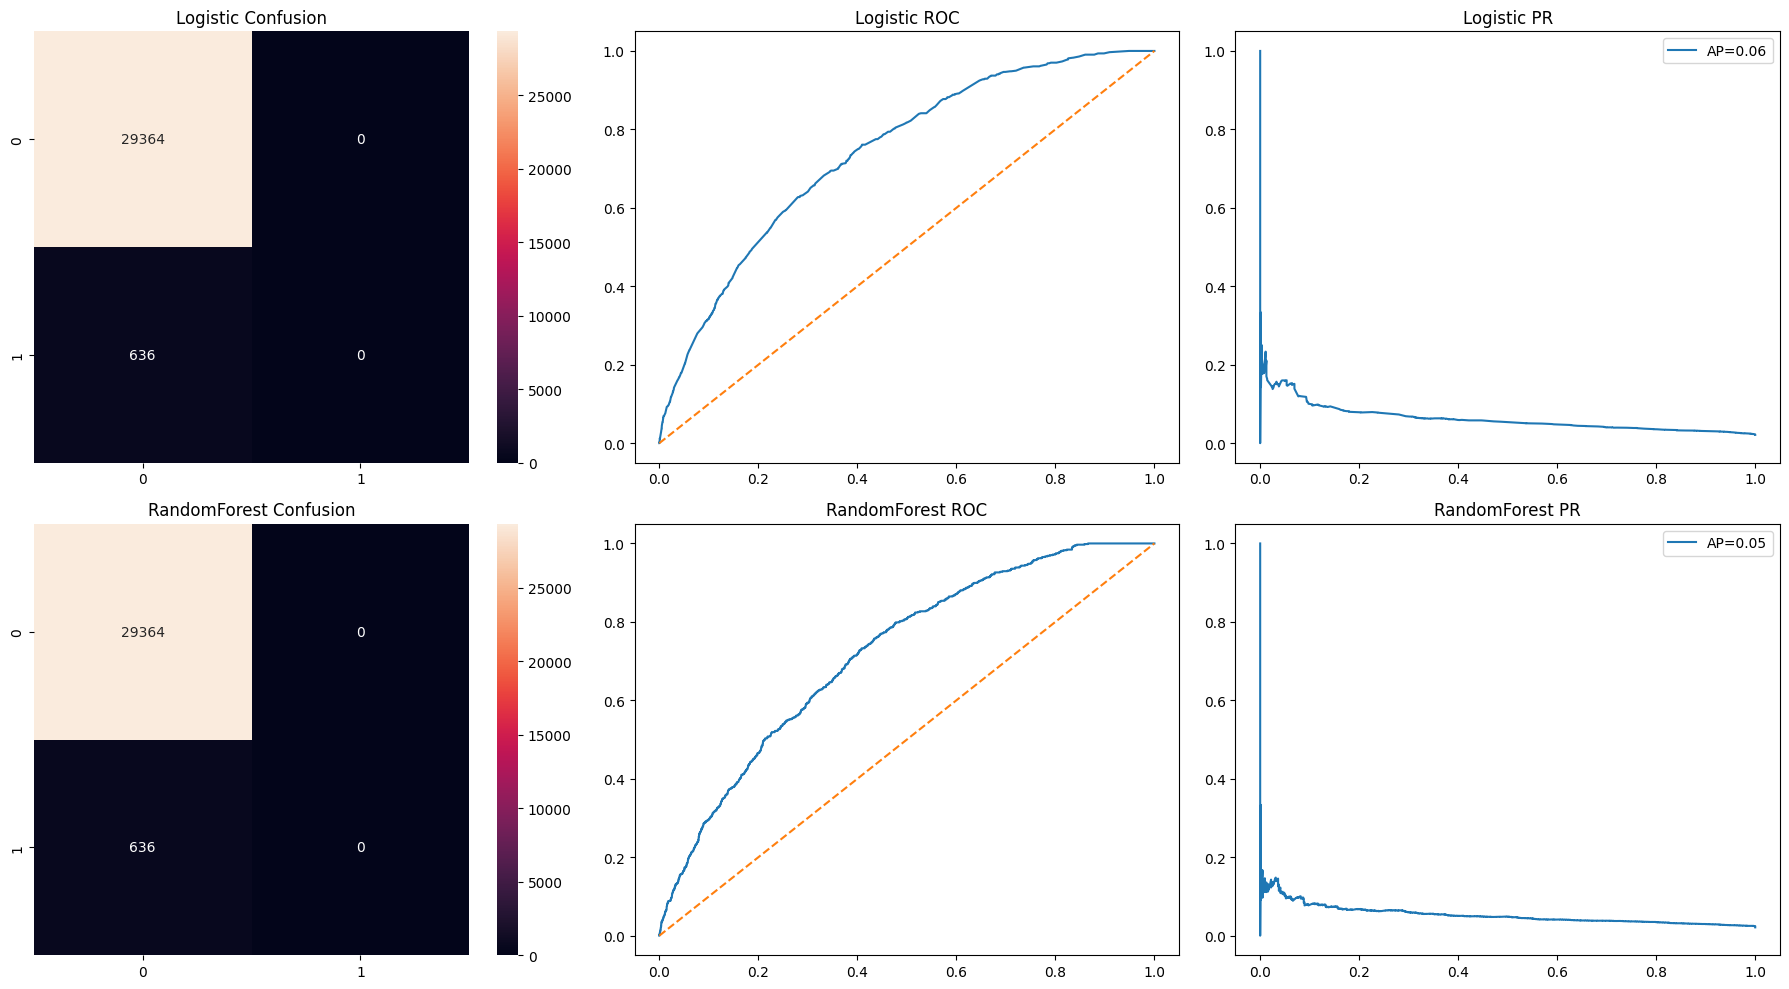

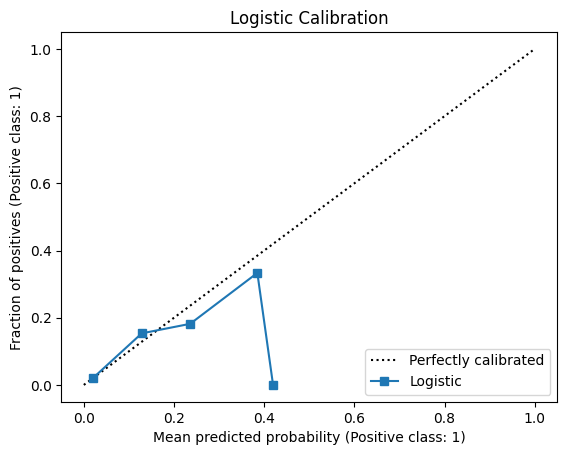

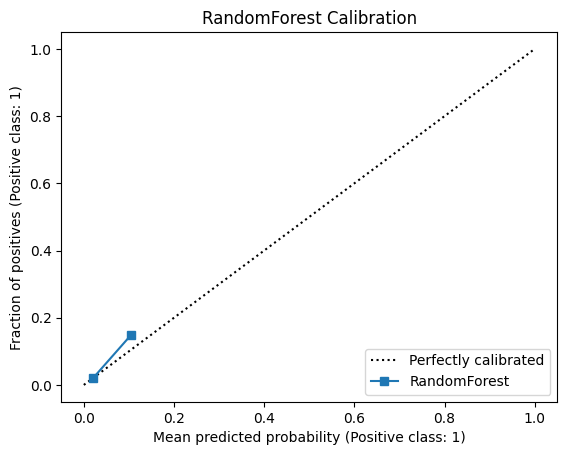

2025-04-23 02:27:50 INFO Logistic Brier score=0.0203
2025-04-23 02:27:50 INFO RandomForest Brier score=0.0204


In [78]:
# Metrics & Plots
fig, axes = plt.subplots(2,3,figsize=(18,10))
for i,(name,clf) in enumerate(calibrated.items()):
    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    # Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i,0])
    axes[i,0].set_title(f"{name} Confusion")
    # ROC
    fpr,tpr,_ = roc_curve(y_test,y_prob)
    axes[i,1].plot(fpr,tpr,label=f"AUC={roc_auc_score(y_test,y_prob):.2f}")
    axes[i,1].plot([0,1],[0,1],"--"); axes[i,1].set_title(f"{name} ROC")
    # PR
    prec,rec,_ = precision_recall_curve(y_test,y_prob)
    axes[i,2].plot(rec,prec,label=f"AP={average_precision_score(y_test,y_prob):.2f}")
    axes[i,2].set_title(f"{name} PR")
    axes[i,2].legend()
plt.tight_layout(); plt.show()

# Calibration curve & Brier
for name,clf in calibrated.items():
    disp = CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins=10, name=name)
    disp.ax_.set_title(f"{name} Calibration")
plt.show()
for name,clf in calibrated.items():
    brier = brier_score_loss(y_test, clf.predict_proba(X_test)[:,1])
    logger.info(f"{name} Brier score={brier:.4f}")


# 8. Explainability

In [ ]:

# Explainability with SHAP (skipped if unavailable)

# %% code
if SHAP_AVAILABLE:
    explainer = shap.TreeExplainer(best_models['RandomForest'])
    shap_vals  = explainer.shap_values(X_test)
    shap.summary_plot(shap_vals[1], X_test, plot_type='bar')
else:
    logger.info("SHAP explainability skipped (shap not installed).")


# 9. Threshold Simulation & A/B Assignment

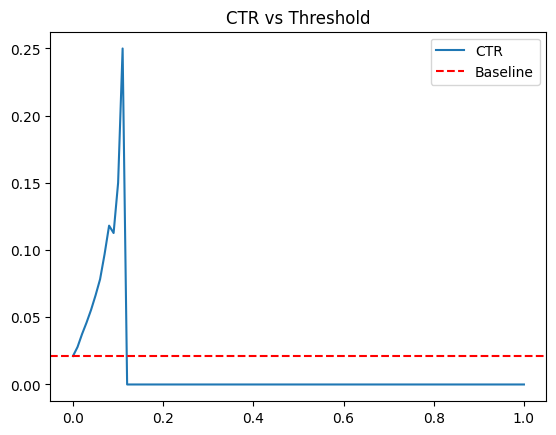

2025-04-23 02:27:51 INFO A/B sample per arm: 2218
2025-04-23 02:27:52 INFO Desired sample size per arm: 2214
2025-04-23 02:27:52 WARNING Treatment pool size 0 < 2214; using top 2214 by score instead.
2025-04-23 02:27:52 INFO Assignments per arm: {'control': 2214, 'treatment': 2214}
2025-04-23 02:27:52 INFO Saved experiment_assignments.csv


In [79]:
def compute_performance(df, group_col):
    grouped = df.groupby(group_col).agg(
        total=('email_id', 'count'),
        opens=('opened', 'sum'),
        clicks=('clicked', 'sum')
    )
    grouped['open_rate'] = grouped['opens'] / grouped['total']
    grouped['ctr'] = grouped['clicks'] / grouped['total']
    return grouped

def simulate_thresholds(y_prob, y_true, thresholds):
    baseline = y_true.mean()
    ctrs, lifts = [], []
    for t in thresholds:
        mask = y_prob >= t
        sel_ctr = y_true[mask].mean() if mask.sum() > 0 else 0
        ctrs.append(sel_ctr)
        lifts.append((sel_ctr - baseline) / baseline * 100 if baseline > 0 else 0)
    return ctrs, lifts


# Simulate lift vs. threshold
thresholds = np.linspace(0,1,101)
ctrs,lifts = simulate_thresholds(
    calibrated["RandomForest"].predict_proba(X_test)[:,1],
    y_test, thresholds
)
plt.plot(thresholds,ctrs,label="CTR"); plt.axhline(y_test.mean(),ls="--",color="red",label="Baseline")
plt.legend(); plt.title("CTR vs Threshold"); plt.show()

# Compute sample size
p1,y_exp = y_test.mean(), 0.035
es = proportion_effectsize(y_exp,p1)
n = NormalIndPower().solve_power(es, power=0.8, alpha=0.05)
logger.info(f"A/B sample per arm: {int(np.ceil(n))}")
# 1) Reconstruct the full feature matrix exactly as during training
df_full = pd.get_dummies(
    email_table,
    columns=['email_text','email_version','weekday','user_country','purchase_bin'],
    drop_first=True
)

# If you created an interaction feature during training:
if 'email_version_personalized' in df_full.columns and 'purchase_bin_High' in df_full.columns:
    df_full['personalized_x_high'] = (
        df_full['email_version_personalized'] * df_full['purchase_bin_High']
    )

# 2) Ensure df_full has exactly the same columns in the same order as X_train
for col in X_train.columns:
    if col not in df_full.columns:
        df_full[col] = 0
# Drop any extra columns
X_full = df_full[X_train.columns]

# 3) Score every email
email_table['score'] = calibrated['RandomForest'].predict_proba(X_full)[:, 1]

# 4) Compute desired sample size per arm from power analysis
baseline_ctr = email_table['clicked'].mean()
expected_treatment_ctr = 0.035  # for example
effect_size = proportion_effectsize(expected_treatment_ctr, baseline_ctr)
n_req = int(np.ceil(
    NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05)
))
logger.info(f"Desired sample size per arm: {n_req}")

# 5) Build treatment/control pools using threshold
threshold = 0.15
treat_pool = email_table[email_table['score'] >= threshold].copy()
ctrl_pool  = email_table[email_table['score'] <  threshold].copy()

# 6) If either pool is too small, fall back to top-N / bottom-N by score
if len(treat_pool) < n_req:
    logger.warning(
        f"Treatment pool size {len(treat_pool)} < {n_req}; "
        f"using top {n_req} by score instead."
    )
    treat_pool = email_table.nlargest(n_req, 'score').copy()

if len(ctrl_pool) < n_req:
    logger.warning(
        f"Control pool size {len(ctrl_pool)} < {n_req}; "
        f"using bottom {n_req} by score instead."
    )
    ctrl_pool = email_table.nsmallest(n_req, 'score').copy()

# 7) Sample exactly n_req from each pool, selecting only needed columns
treat_sample = treat_pool[['email_id','score']].sample(n_req, random_state=SEED)
ctrl_sample  = ctrl_pool [['email_id','score']].sample(n_req, random_state=SEED)

# 8) Concatenate, shuffle, and reset index
assignments = pd.concat([
    treat_sample.assign(group='treatment'),
    ctrl_sample .assign(group='control')
], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

# Sanity checks
assert len(assignments) == 2 * n_req
counts = assignments['group'].value_counts().to_dict()
logger.info(f"Assignments per arm: {counts}")

# 9) Export to CSV for your campaign system (only email_id and group needed)
assignments[['email_id','group']].to_csv(
    "experiment_assignments.csv",
    index=False
)
logger.info("Saved experiment_assignments.csv")


# 10. Statistical Tests

In [80]:
# 10) Merge back to compute observed CTRs and run the z‑test
res = assignments.merge(
    email_table[['email_id','clicked']],
    on='email_id',
    how='left'
)
res['clicked'] = res['clicked'].fillna(0).astype(int)

summary = (
    res
    .groupby('group')['clicked']
    .agg(clicks='sum', emails_sent='count')
    .reset_index()
)
summary['ctr'] = summary['clicks'] / summary['emails_sent']
print(summary)

# 11) Two‑sample z‑test for CTR difference
ctrl = summary[summary['group']=='control'].iloc[0]
trt  = summary[summary['group']=='treatment'].iloc[0]
counts = [int(ctrl['clicks']), int(trt['clicks'])]
nobs   = [int(ctrl['emails_sent']), int(trt['emails_sent'])]
z_stat, p_val = proportions_ztest(counts, nobs)
print(f"Control CTR = {ctrl['ctr']:.2%}, Treatment CTR = {trt['ctr']:.2%}")
print(f"z = {z_stat:.2f}, p = {p_val:.3e}")


       group  clicks  emails_sent       ctr
0    control      51         2214  0.023035
1  treatment     309         2214  0.139566
Control CTR = 2.30%, Treatment CTR = 13.96%
z = -14.19, p = 1.107e-45
